In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Loading the datasets
df = pd.read_csv("training_set_VU_DM.csv", index_col=0)
df_test = pd.read_csv("test_set_VU_DM.csv", index_col=0)

# Log transformation for 'price_usd'
df['log_price_usd'] = np.log1p(df['price_usd'])

In [2]:
# # Analysis plots
# plt.hist(df['log_price_usd'], bins=50)
# plt.title('Distribution of log_price_usd')
# plt.show()
#
# plt.scatter(df['srch_length_of_stay'], df['log_price_usd'])
# plt.title('log_price_usd vs Length of Stay')
# plt.xlabel('Length of Stay')
# plt.ylabel('Log Price USD')
# plt.show()
#
# plt.scatter(df['srch_booking_window'], df['log_price_usd'])
# plt.title('log_price_usd vs Booking Window')
# plt.xlabel('Booking Window')
# plt.ylabel('Log Price USD')
# plt.show()

In [3]:
# # Calculating averages
# grouped = df.groupby('srch_length_of_stay')['log_price_usd'].mean()
# plt.plot(grouped)
# plt.title('Average log_price_usd by Length of Stay')
# plt.xlabel('Length of Stay')
# plt.ylabel('Average Log Price USD')
# plt.show()
#
# plt.scatter(df['prop_log_historical_price'], df['log_price_usd'])
# plt.title('log_price_usd vs Log Historical Price')
# plt.xlabel('Log Historical Price')
# plt.ylabel('Log Price USD')
# plt.show()
#
# grouped = df.groupby('prop_log_historical_price')['log_price_usd'].mean()
# plt.plot(grouped)
# plt.title('Average log_price_usd by Log Historical Price')
# plt.xlabel('Log Historical Price')
# plt.ylabel('Average Log Price USD')
# plt.show()

In [4]:
# Date processing and creating CSV
df['date_time'] = pd.to_datetime(df['date_time'])
df['month'] = df['date_time'].dt.month

df['prop_historical_price'] = np.exp(df['prop_log_historical_price'])

property_price_range = df.groupby(['prop_id', 'month'])['price_usd'].agg(['min', 'max']).reset_index()
property_price_range.rename(columns={'min': 'min_price', 'max': 'max_price'}, inplace=True)

property_length_of_stay = df.groupby(['prop_id', 'month'])['srch_length_of_stay'].agg(['min', 'max']).reset_index()
property_length_of_stay.rename(columns={'min': 'min_length_of_stay', 'max': 'max_length_of_stay'}, inplace=True)

property_info = pd.merge(property_price_range, property_length_of_stay, on=['prop_id', 'month'])
additional_info = df[['prop_id', 'month', 'site_id', 'prop_historical_price', 'visitor_hist_adr_usd', 'price_usd']].drop_duplicates()
property_info = pd.merge(property_info, additional_info, on=['prop_id', 'month'])

conditions = [(property_info['min_price'] / property_info['min_length_of_stay'] * property_info['max_length_of_stay']) > property_info['max_price'],
              property_info['min_length_of_stay'] == property_info['max_length_of_stay']]
choices = [1, 0]
property_info['price_per_night'] = np.select(conditions, choices, default=0)

conditions = [property_info['price_per_night'] == 1,
              property_info['price_per_night'] == 0]
choices = [(property_info['min_price'] + property_info['max_price']) / 2,
           ((property_info['min_price'] / property_info['min_length_of_stay']) + (property_info['max_price'] / property_info['max_length_of_stay'])) / 2]
property_info['avg_price'] = np.select(conditions, choices)
property_info['log_avg_price'] = np.log1p(property_info['avg_price'])

property_info.to_csv('property_info.csv', index=False)

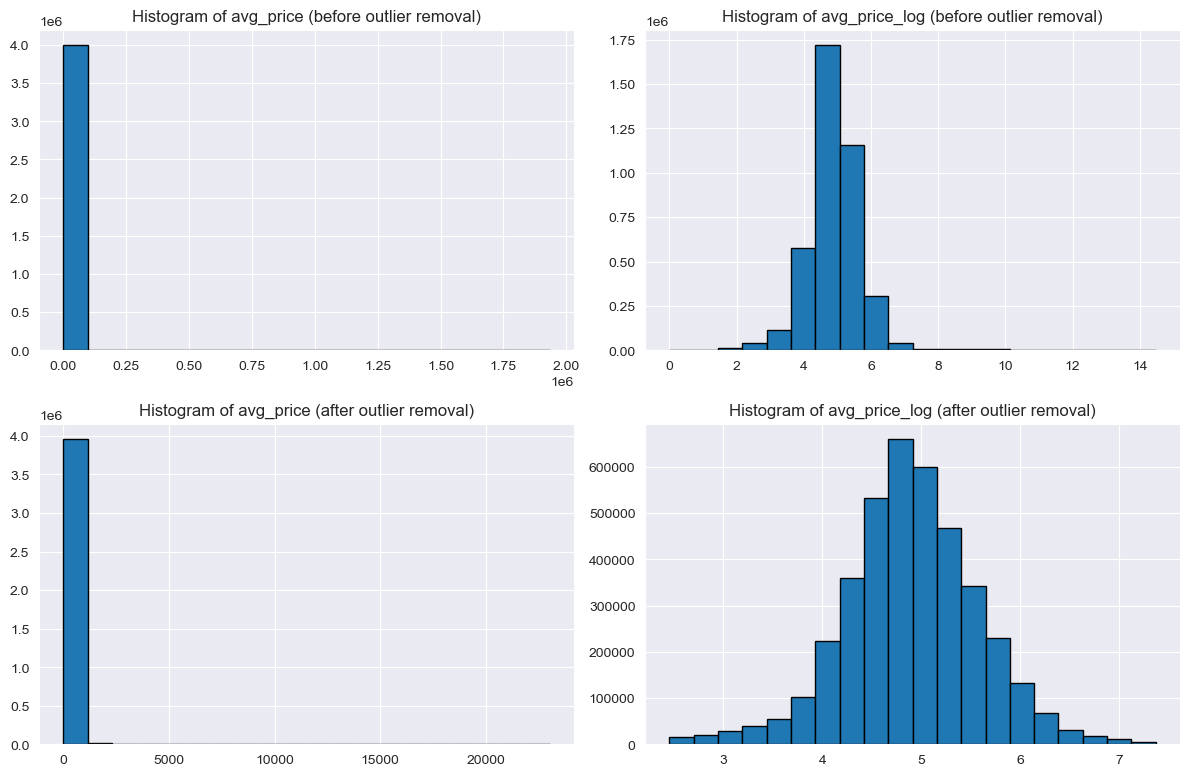

In [5]:
from scipy.stats import zscore

# Checking for outliers in avg_price and whether to use avg_price or log_avg_price
property_info['avg_price_log'] = np.log1p(property_info['avg_price'])
z_scores_before = zscore(property_info['avg_price'])
z_scores_after = zscore(property_info['avg_price_log'])

outliers_before = property_info[np.abs(z_scores_before) > 3]
outliers_after = property_info[np.abs(z_scores_after) > 3]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(property_info['avg_price'], bins=20, edgecolor='black')
axs[0, 0].set_title('Histogram of avg_price (before outlier removal)')
axs[0, 1].hist(property_info['avg_price_log'], bins=20, edgecolor='black')
axs[0, 1].set_title('Histogram of avg_price_log (before outlier removal)')

property_info_no_outliers_before = property_info.loc[~property_info.index.isin(outliers_before.index)]
property_info_no_outliers_after = property_info.loc[~property_info.index.isin(outliers_after.index)]

axs[1, 0].hist(property_info_no_outliers_before['avg_price'], bins=20, edgecolor='black')
axs[1, 0].set_title('Histogram of avg_price (after outlier removal)')
axs[1, 1].hist(property_info_no_outliers_after['avg_price_log'], bins=20, edgecolor='black')
axs[1, 1].set_title('Histogram of avg_price_log (after outlier removal)')

plt.tight_layout()
plt.show()


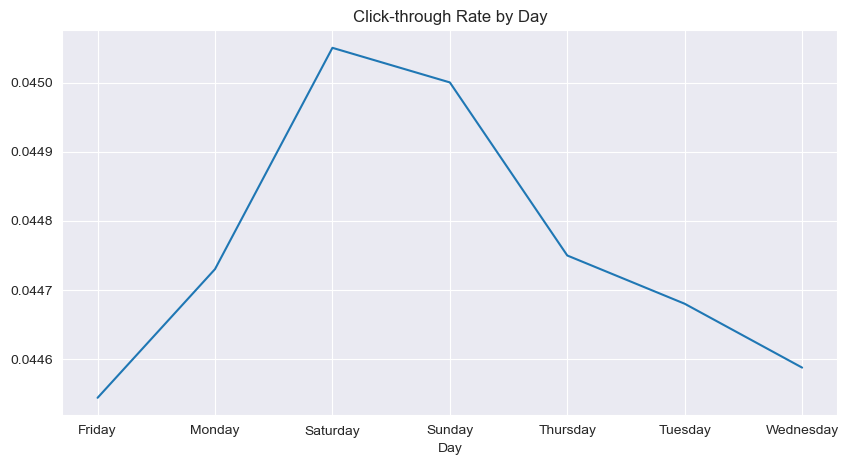

In [6]:
# Break down date to more features - year - month - day - hour
df['date_time'] = pd.to_datetime(df['date_time'])
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour
df['day_string'] = df['date_time'].dt.day_name()

click_rate_by_hour = df.groupby('day_string')['click_bool'].mean()
click_rate_by_hour.plot(kind='line', figsize=(10, 5))
plt.title("Click-through Rate by Day")
plt.xlabel("Day")
plt.show()


In [7]:
# # Convert competitor info to aggregated_info
# rate_cols = [f'comp{i}_rate' for i in range(1, 9)]
# inv_cols = [f'comp{i}_inv' for i in range(1, 9)]
# percent_diff_cols = [f'comp{i}_rate_percent_diff' for i in range(1, 9)]
#
# df['avg_rate'] = df[rate_cols].mean(axis=1)
# df['avg_inv'] = df[inv_cols].mean(axis=1)
# df['avg_rate_percent_diff'] = df[percent_diff_cols].mean(axis=1)
#
# df.drop(columns=rate_cols + inv_cols + percent_diff_cols, inplace=True)
#
# # Imputation
# drop_list = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score', 'gross_bookings_usd']
# zero_list = ['avg_rate', 'avg_inv', 'avg_rate_percent_diff']
# mean_list = ['prop_location_score2', 'prop_review_score', 'orig_destination_distance']
#
# df.drop(drop_list, axis=1, inplace=True)
#
# for col in zero_list:
#     df[col] = df[col].fillna(0)
#
# for col in mean_list:
#     df[col] = df[col].fillna(df[col].mean())


In [8]:
# # Modeling and evaluation
# from surprise import SVD
# from surprise import Dataset
# from surprise import Reader
# from surprise.model_selection import cross_validate, train_test_split
# from sklearn.metrics import ndcg_score
# import numpy as np
#
# df.reset_index(inplace=True)
# df.rename(columns={'index': 'srch_id'}, inplace=True)
# df['relevance'] = df['booking_bool'] * 5 + df['click_bool'] * (df['booking_bool'] == 0)
#
# y = df['relevance']
# X = df.drop(columns=['relevance', 'booking_bool', 'click_bool'])
#
# reader = Reader(rating_scale=(0, 5))
# data = Dataset.load_from_df(df[['srch_id', 'prop_id', 'relevance']], reader)
# trainset, testset = train_test_split(data, test_size=.25)
#
# model = SVD()
# model.fit(trainset)
# predictions = model.test(testset)
#
# y_true = np.array([pred.r_ui for pred in predictions])
# y_score = np.array([pred.est for pred in predictions])
# y_true = np.reshape(y_true, (1, -1))
# y_score = np.reshape(y_score, (1, -1))
# ndcg = ndcg_score(y_true, y_score)
# print(f"NDCG: {ndcg}")
#
# df_test.reset_index(inplace=True)
# df_test.rename(columns={'index': 'srch_id'}, inplace=True)
# df_test['predicted_relevance'] = df_test.apply(lambda row: model.predict(row['srch_id'], row['prop_id']).est, axis=1)
# print(df_test)
#
# df_test_sorted = df_test.sort_values(by='predicted_relevance', ascending=False)
# df_test_sorted[['srch_id', 'prop_id']].to_csv('prediction_SVD.csv', index=False, header=['srch_id', 'prop_id'], sep=',')


## Model 2: XGBoost, return of the XG

In [7]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load datasets
df = pd.read_csv("training_set_VU_DM.csv", index_col=0)
property_info = pd.read_csv("property_info.csv")

# Define the chunk size for merging
chunk_size = 10000

# Create an empty list to store the merged chunks
merged_chunks = []

# Merge df and property_info in chunks based on prop_id
for i in range(0, len(df), chunk_size):
    chunk = df.iloc[i:i+chunk_size]
    merged_chunk = pd.merge(chunk, property_info[['prop_id', 'log_avg_price']], how='left', on='prop_id')
    merged_chunks.append(merged_chunk)

# Concatenate the merged chunks
df = pd.concat(merged_chunks)

# Remove rows with missing values
df = df.dropna()

# Convert boolean columns to integers
df['click_bool'] = df['click_bool'].astype(int)
df['booking_bool'] = df['booking_bool'].astype(int)

# Define features (X) and target (y)
X = df[['month', 'log_avg_price']]
y = df['booking_bool']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Model Accuracy: ", accuracy)
print("Confusion Matrix: \n", confusion_mat)


MemoryError: Unable to allocate 908. MiB for an array with shape (24, 4958347) and data type float64